# Frozen Lake

Apply SARSA(lambda) and Q(lambda) agents on the Frozen Lake (FL) environment using a discount factor gamma=0.99. For the comparison, you can plot only states (0, 6, 10). Get also the optimal state-value functions using Dynamic Programming.

Remember: FL is a simple grid-world environment. It has 16 states and 4 actions. The goal of the agent is to go from a start location to a goal location while avoiding falling into holes. All transitions landing on the goal state  provide a +1 reward, while every other transition in the entire grid world provides no reward. The challenge is that the surface of the lake is frozen, and therefore slippery. So actions have stochastic effects, and the agent moves only a third of the time as intended. The other two-thirds is split evenly in orthogonal directions.

FL is a more challenging environment than Slippery Walk environment. Therefore, one of the most important changes you need to make is to increase the number of episodes the agent interacts with the environment. While in the Slippery Walk environment we allow the agent to interact for only 2.000 episodes, in the FL environment, let your agent gather experience for 10.000 episodes.

1 - Import the FrozenLake environment

In [1]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'FrozenLake-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym

frozen_lake = gym.make('FrozenLake-v1', render_mode="rgb_array")

LEFT, DOWN, RIGHT, UP = range(4)

2 - Solve the environment using Dynamic Programming:

In [2]:
#  YOUR CODE HERE

# Copy the value iteration algorithm from the lecture notes.

import numpy as np

def value_iteration(P, gamma=0.99, theta=1e-10):
    
    # first thing is to initialize a state-value function.
    V = np.zeros(len(P))
    
    # We get in this loop and initialize a Q-function to zero.
    while True:
        Q = np.zeros((len(P), len(P[0])))
        
        # then, for every transition of every action in every 
        # state, we...
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    
                    # ...calculate the action-value function
                    # notice, using V, which is the old truncated estimate
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        
        # After each sweep over the state space, make sure 
        # the state-value function keeps changing. 
        # Otherwise, we found the optimal V-function and should break out
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
            
        # we don’t need a separate policy-improvement phase. 
        # It’s not a direct replacement, but instead a combination of 
        # improvement and evaluation    
        V = np.max(Q, axis=1)
    
    # only at the end do we extract the optimal policy and return it 
    # along with the optimal state-value function.
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return V, pi

In [3]:
# YOUR CODE HERE

# Solve the problem using the algorithm and exploiting the MDP dynamics

P = frozen_lake.env.unwrapped.P
optimal_V, optimal_pi = value_iteration(P, gamma=0.99)

3 - Print the values of the optimal state-value function

In [4]:
# YOUR CODE HERE

# Copy the print_state_value_function function from the lecture notes and use it to
# print the state-value function for the best policy

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

print_state_value_function(optimal_V, P, prec=4)

State-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |


4 - Implement the SARSA(lambda) algorithm and use it against the FL environment

In [5]:
# YOUR CODE HERE

# Copy the decay_schedule function from the lecture notes

def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [6]:
# YOUR CODE HERE

# Copy the decay_discounts function from the lecture notes

def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts


In [7]:
# YOUR CODE HERE

# Copy the select_action function from the lecture notes

def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [8]:
# YOUR CODE HERE

# Copy the sarsa_lambda function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n), to call the step() function using 
# the Gymnasium interface (5 outputs), and extract the id of the starting state from the first 
# output of the reset() function.


def sarsa_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
                lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # eligibility traces
    E = np.zeros((nS, nA), dtype=float)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        state = state[0]
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # decay the eligibility matrix
            E = gamma * lambda_ * E 
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [9]:
# YOUR CODE HERE

# Apply sarsa(lambda) for 10.000 episodes ans gamma = 0.99

Q_sarsa_lambda, V_sarsa_lambda, pi_sarsa_lambda, Q_track_sarsa_lambda, V_track_sarsa_lambda, pi_track_sarsa_lambda = sarsa_lambda(frozen_lake, decay_episodes=2500, n_episodes=10000, gamma=0.99)

5 - Plot the state-value functions for states (0, 6, 10) for SARSA(lambda) and compare with the optimal values. Than observe how the agent struggle to estimate the optimal state-value function. 

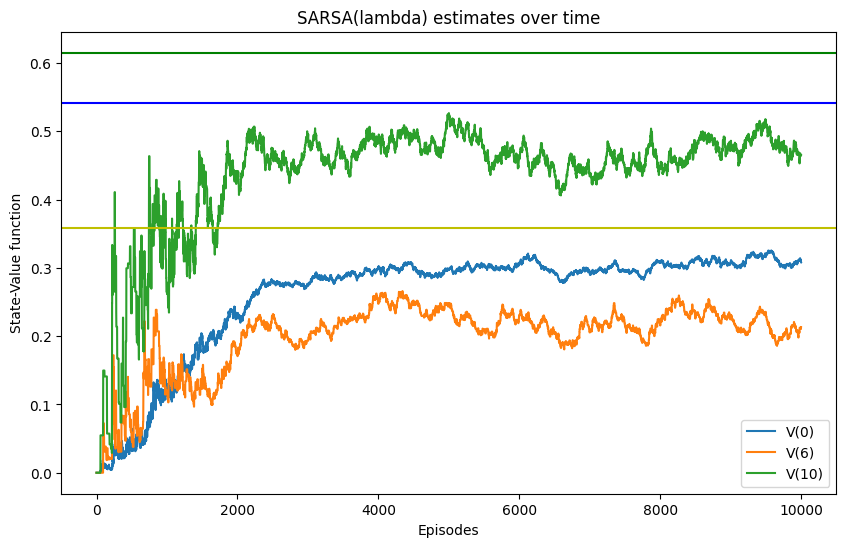

In [10]:
# YOUR CODE HERE

# import matplotlib.pyplot as plt and plot the V_track_sarsa_lambda for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

import matplotlib.pyplot as plt

legends = ['V(0)','V(6)','V(10)']

plt.figure(figsize=(10,6))

plt.plot(V_track_sarsa_lambda[:,[0,6,10]])
plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')
plt.title('SARSA(lambda) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

6 - Implement the Q(lambda) algorithm and use it against the FL environment

In [12]:
# YOUR CODE HERE

# Copy the q_lambda function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n), to call the step() function using 
# the Gymnasium interface (5 outputs), and extract the id of the starting state from the first 
# output of the reset() function.

def q_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
             lambda_=0.5, replacing_traces=True, n_episodes=2000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
        
    E = np.zeros((nS, nA), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        E.fill(0)
        
        state, done = env.reset(), False
        state = state[0]
        
        # notice: we are preselecting the action as in SARSA, (we didn’t do that in Q-learning) 
        # this is because we need to check whether our next action is greedy for deciding
        # to decay the eligibility trace
        action = select_action(state, Q, epsilons[e])
        
        while not done:
            
            next_state, reward, done, _, _ = env.step(action)
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, Q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            # still calculate the TD target as in regular Q-learning, using the max
            td_target = reward + gamma * Q[next_state].max()
            
            # and use the TD target to calculate the TD error
            td_error = td_target - Q[state][action]
            
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # if the action we’ll take on the next state (which we already selected) is a greedy action, 
            # then we decay the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning about the greedy policy
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [13]:
# YOUR CODE HERE

# Apply q(lambda) for 10.000 episodes ans gamma = 0.99

Q_q_lambda, V_q_lambda, pi_q_lambda, Q_track_q_lambda, V_track_q_lambda, pi_track_q_lambda = q_lambda(frozen_lake, decay_episodes=2500, n_episodes=10000, gamma=0.99)

7 - Plot the state-value functions for states (0, 6, 10) for Q(lambda) and compare with the optimal values. Than observe as Q(lambda) agent is moving the estimates of the optimal state-value function toward the true values, unlike SARSA(lambda). Now, to be clear, this is a matter of the number of steps, also SARSA(lambda) would converge to the true values if given more episodes.

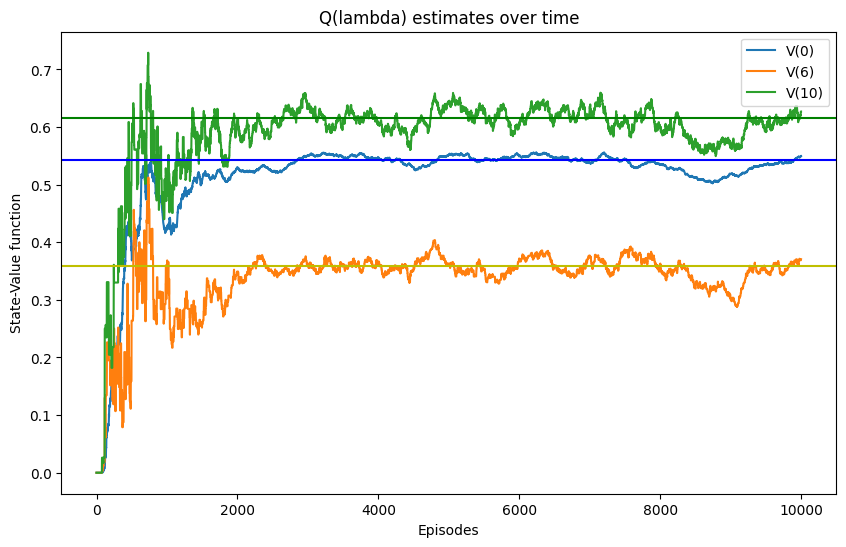

In [14]:
# YOUR CODE HERE

# import matplotlib.pyplot as plt and plot the V_track_q_lambda for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

plt.figure(figsize=(10,6))

plt.plot(V_track_q_lambda[:,[0,6,10]])
plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')
plt.title('Q(lambda) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

8 - Plot the state-value function mean absolute error for the two methods.

In [30]:
# YOUR CODE HERE

# Copy the moving average function from the lecture notes

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

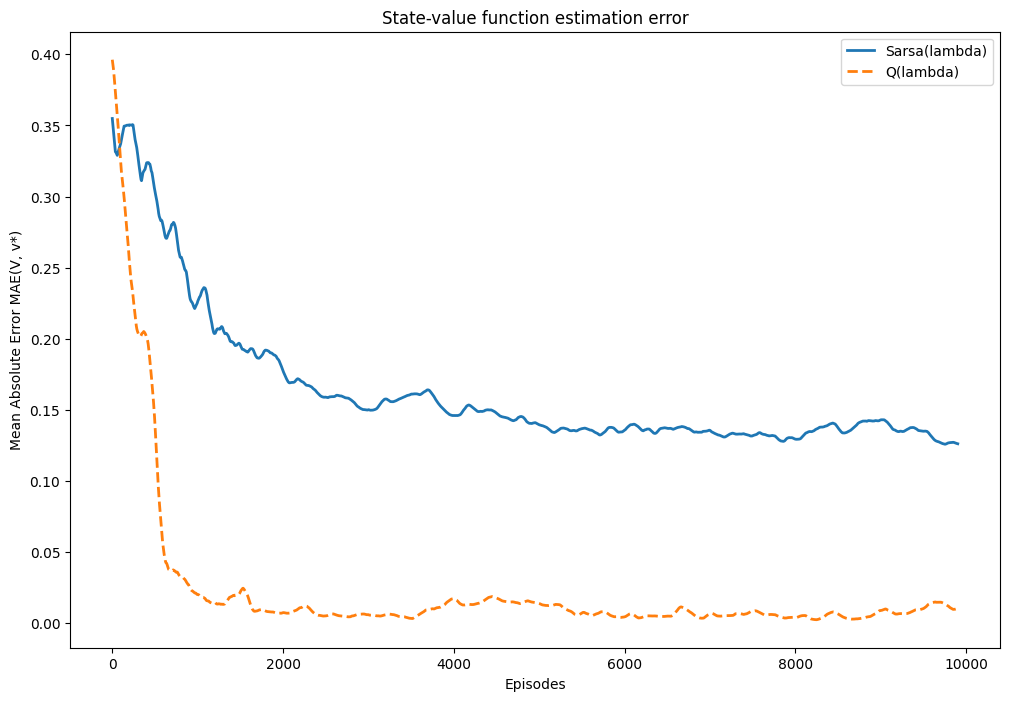

In [31]:
# YOUR CODE HERE

# plot the moving average of the absolute error between the optimal_V and the V_track_sarsa_lambda and V_track_q_lambda

plt.figure(figsize=(12,8))

plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), '-', linewidth=2, label='Sarsa(lambda)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), '--', linewidth=2, label='Q(lambda)')

plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()